<h1>AES-128 images encrypt and decrypt base on multiple DMA transfers </h1>

In [ ]:
import ipywidgets as widgets
from IPython.display import display, FileLink
from PIL import Image as PILImage
import io
import numpy as np
from pynq import allocate, Overlay

# Key variable (16 bytes)
key = "000102030405060708090a0b0c0d0e0f"
key_bytes = bytes.fromhex(key)

# Create file upload widget
file_upload = widgets.FileUpload(
    accept= '.jpg, .jpeg',  # Accept only certain file types
    multiple=False  # Allow only one file to be uploaded
)

# Create output widgets
output_widget = widgets.Output()
download_link_img = widgets.Output()
download_link_byte_map = widgets.Output()
download_link_buffer_txt = widgets.Output()

# Load the overlay
ol = Overlay("/home/xilinx/jupyter_notebooks/AES-128_Image_Encrypt_Decrypt/overlays/AES_ECB_128_design.bit") 

def image_to_byte_map(img):
    """Converts PIL image to a byte map (hexadecimal representation)."""
    img_bytes = img.tobytes()
    byte_map_str = ' '.join([format(byte, '02x') for byte in img_bytes])
    return byte_map_str

def get_image_details(img):
    """Returns size of image in pixels and bytes, and color mode."""
    size = img.size
    mode = img.mode
    img_bytes = len(img.tobytes())
    return size, mode, img_bytes

def adjust_buffer_length(buffer, alignment=16):
    """Adjusts buffer length to be a multiple of alignment bytes."""
    current_length = len(buffer)
    new_length = (current_length + alignment - 1) // alignment * alignment  # Round up to the nearest multiple of alignment
    if new_length > current_length:
        buffer = np.concatenate((buffer, np.zeros(new_length - current_length, dtype=np.uint8)))
    return buffer, new_length

def save_image(img, filename):
    """Save PIL image to file."""
    img.save(filename)

def save_byte_map(byte_map_str, filename):
    """Save byte map data to text file."""
    with open(filename, 'w') as f:
        f.write(byte_map_str)

def save_buffer_txt(buffer_data, filename):
    """Save buffer data to text file."""
    with open(filename, 'w') as f:
        byte_list = ' '.join([format(byte, '02x') for byte in buffer_data])
        f.write(byte_list)

def on_file_upload(change):
    with output_widget:
        output_widget.clear_output()
        download_link_img.clear_output()
        download_link_byte_map.clear_output()
        download_link_buffer_txt.clear_output()
        
        # Get uploaded file
        uploaded_filename = next(iter(file_upload.value))
        content = file_upload.value[uploaded_filename]['content']
        
        # Load image from content
        img = PILImage.open(io.BytesIO(content))
        
        # Get image details
        size, mode, img_bytes = get_image_details(img)
        
        # Print image details
        print(f"Image size: {size[0]} x {size[1]} pixels")
        print(f"Image size in bytes: {img_bytes} bytes")
        print(f"Color mode: {mode}")
        
        # Convert image to byte map
        byte_map_str = image_to_byte_map(img)
        
        # Save byte map to a text file
        txt_filename = uploaded_filename.replace('.', '_') + '_byte_map.txt'
        save_byte_map(byte_map_str, txt_filename)
        
        # Display download link for byte map
        with download_link_byte_map:
            display(FileLink(txt_filename, result_html_prefix="Download Byte Map: "))
        
        # Allocate input buffer and move data
        byte_list = [int(byte, 16) for byte in byte_map_str.split()]
        total_size_in_bytes = len(byte_list)
        
        # Calculate number of chunks
        chunk_size = 0x4000  # 16,384 bytes
        num_chunks = (total_size_in_bytes + chunk_size - 1) // chunk_size
        
        # Create final output buffer
        output_buffer_final = allocate(shape=(total_size_in_bytes,), dtype=np.uint8)
        
        # DMA transfer
        dma = ol.axi_dma_0
        dma_send = dma.sendchannel
        dma_recv = dma.recvchannel
        
        for i in range(num_chunks):
            # Calculate start and end indices for the current chunk
            start_idx = i * chunk_size
            end_idx = min(start_idx + chunk_size, total_size_in_bytes)
            
            # Prepare input buffer for the current chunk
            chunk_data = byte_list[start_idx:end_idx]
            input_buffer = allocate(shape=(len(chunk_data) + len(key_bytes),), dtype=np.uint8)
            
            # Add key to the input buffer
            input_buffer[:len(key_bytes)] = np.frombuffer(key_bytes, dtype=np.uint8)
            
            # Add chunk data to the input buffer
            input_buffer[len(key_bytes):] = np.array(chunk_data, dtype=np.uint8)
            
            # Adjust input buffer length to be a multiple of 16 bytes
            input_buffer, new_length = adjust_buffer_length(input_buffer)
            
            # Allocate output buffer for the current chunk
            output_buffer = allocate(shape=(new_length - len(key_bytes),), dtype=np.uint8)
            
            # Perform DMA transfer for the current chunk
            dma_send.transfer(input_buffer)
            dma_recv.transfer(output_buffer)
            dma_send.wait()
            dma_recv.wait()
            
            # Copy the output buffer to the final output buffer
            output_buffer_final[start_idx:end_idx] = output_buffer[:end_idx - start_idx]
            
            # Free the input and output buffers for the current chunk
            input_buffer.freebuffer()
            output_buffer.freebuffer()

        # Convert output_buffer_final back to image
        output_img = PILImage.frombytes(mode, size, bytes(output_buffer_final))
        
        # Display processed image
        display(output_img)
        
        # Save processed image
        processed_img_filename = uploaded_filename.replace('.', '_') + '_processed.png'
        save_image(output_img, processed_img_filename)
        
        # Display download link for processed image
        with download_link_img:
            display(FileLink(processed_img_filename, result_html_prefix="Download Processed Image: "))

        # Save output buffer data to text file
        buffer_txt_filename = uploaded_filename.replace('.', '_') + '_output_buffer.txt'
        save_buffer_txt(bytes(output_buffer_final), buffer_txt_filename)

        # Display download link for output buffer text file
        with download_link_buffer_txt:
            display(FileLink(buffer_txt_filename, result_html_prefix="Download Output Buffer Text: "))
        
        # Free the final output buffer
        output_buffer_final.freebuffer()

# Attach file upload handler
file_upload.observe(on_file_upload, names='value')

# Display widgets
display(file_upload, output_widget, download_link_img, download_link_byte_map, download_link_buffer_txt)


FileUpload(value={}, accept='.jpg, .jpeg', description='Upload')

Output()

Output()

Output()

Output()

FileUpload(value={}, accept='.txt', description='Upload')

Uploaded file size in bytes: 49152


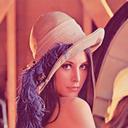

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image as PILImage
import numpy as np
from pynq import allocate, Overlay

# Key variable (16 bytes)
key = "000102030405060708090a0b0c0d0e0f"
key_bytes = bytes.fromhex(key)

# Load the overlay (adjust path as per your setup)
overlay = Overlay("/home/xilinx/jupyter_notebooks/AES-128_Image_Encrypt_Decrypt/overlays/AES_ECB_128_design.bit")

# DMA channels
dma = overlay.axi_dma_0
dma_send = dma.sendchannel
dma_recv = dma.recvchannel

# Create file upload widget
file_upload = widgets.FileUpload(
    accept='.txt',  # Accept only certain file types
    multiple=False  # Allow only one file to be uploaded
)

def handle_upload(change):
    file_name, file_info = next(iter(file_upload.value.items()))
    content = file_info['content'].decode('utf-8').replace(' ', '').strip()  # Remove spaces and decode
    
    # Convert hex string to bytes
    byte_list = bytes.fromhex(content)
    
    # Step 1: Calculate the number of bytes in the uploaded file
    file_size = len(byte_list)
    print(f"Uploaded file size in bytes: {file_size}")

    # Step 2: Determine the number of chunks based on max packet size
    max_packet_size = 0x4000  # 16,384 bytes
    num_chunks = (file_size + max_packet_size - 1) // max_packet_size
    
    # Step 3: Create final output buffer
    output_buffer_final = allocate(shape=(file_size,), dtype=np.uint8)
    
    for i in range(num_chunks):
        # Calculate start and end indices for the current chunk
        start_idx = i * max_packet_size
        end_idx = min(start_idx + max_packet_size, file_size)
        
        # Prepare input buffer for the current chunk
        chunk_data = byte_list[start_idx:end_idx]
        input_buffer = allocate(shape=(len(chunk_data) + len(key_bytes),), dtype=np.uint8)
        
        # Add key to the input buffer
        input_buffer[:len(key_bytes)] = np.frombuffer(key_bytes, dtype=np.uint8)
        
        # Add chunk data to the input buffer
        input_buffer[len(key_bytes):] = np.frombuffer(chunk_data, dtype=np.uint8)
        
        # Allocate output buffer for the current chunk
        output_buffer = allocate(shape=(len(chunk_data),), dtype=np.uint8)
        
        # Perform DMA transfer for the current chunk
        dma_send.transfer(input_buffer)
        dma_recv.transfer(output_buffer)
        dma_send.wait()
        dma_recv.wait()
        
        # Copy the output buffer to the final output buffer
        output_buffer_final[start_idx:end_idx] = output_buffer[:end_idx - start_idx]
        
        # Free the input and output buffers for the current chunk
        input_buffer.freebuffer()
        output_buffer.freebuffer()

    # Convert output_buffer_final back to image (adjust as per your design)
    output_img = PILImage.frombytes('RGB', (128 , 128), bytes(output_buffer_final)) #change mode and size for each image
    
    # Display processed image
    display(output_img)
    
    # Free the final output buffer
    output_buffer_final.freebuffer()

# Attach the handle_upload function to the file_upload widget
file_upload.observe(handle_upload, names='value')

# Display the file upload widget
display(file_upload)
